In [1]:
import pandas as pd
import json
import os
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
sns.set(style='ticks', context='paper', font='CMU Sans Serif')
from collections import defaultdict

In [26]:
tmp_dict=defaultdict(lambda:0)
with open(f'/data1/lichenni/projects/flow_simulation/parsimon-eval/expts/fig_7/data/1/ns3/flows.txt') as file:
    for line in file:
        tmp=line.rstrip().split(' ')
        if len(tmp)==7:
            key_tuple=(tmp[1],tmp[2])
            tmp_dict[key_tuple]+=1
key=max(tmp_dict, key=tmp_dict.get)
print(key,tmp_dict[key])

('596', '4955') 15


In [23]:
final_dic=defaultdict(lambda:[])
for mix_id in range(191):
    tmp_dict=defaultdict(lambda:0)
    with open(f'/data1/lichenni/projects/flow_simulation/parsimon-eval/expts/fig_8/data/{mix_id}/ns3/flows.txt') as file:
    # with open(f'/data1/lichenni/projects/flow_simulation/parsimon-eval/expts/fig_7/data/1/ns3/flows.txt') as file:
        for line in file:
            tmp=line.rstrip().split(' ')
            if len(tmp)==7:
                key_tuple=(tmp[1],tmp[2])
                tmp_dict[key_tuple]+=1
    key=max(tmp_dict, key=tmp_dict.get)
    final_dic[key].append(mix_id)
    print(key,tmp_dict[key])

('223', '222') 4972
('223', '222') 4972
('223', '222') 4972
('255', '220') 875
('255', '220') 875
('201', '43') 202
('201', '43') 202
('201', '43') 202
('255', '220') 875
('255', '220') 875
('223', '222') 4972
('223', '222') 4972
('223', '222') 4972
('201', '43') 202
('223', '222') 4972
('255', '220') 875
('255', '220') 875
('201', '43') 202
('255', '220') 875
('223', '222') 4972
('255', '220') 875
('223', '222') 4972
('223', '222') 4972
('223', '222') 4972
('201', '43') 202
('255', '220') 875
('255', '220') 875
('201', '43') 202
('255', '220') 875
('201', '43') 202
('223', '222') 4972
('223', '222') 4972
('201', '43') 202
('201', '43') 202
('223', '222') 4972
('255', '220') 875
('255', '220') 875
('223', '222') 4972
('223', '222') 4972
('255', '220') 875
('223', '222') 4972
('255', '220') 875
('223', '222') 4972
('223', '222') 4972
('201', '43') 202
('201', '43') 202
('255', '220') 875
('255', '220') 875
('201', '43') 202
('255', '220') 875
('255', '220') 875
('255', '220') 875
('223'

In [25]:
for key in final_dic:
    print(key,len(final_dic[key]))

('223', '222') 65
('255', '220') 70
('201', '43') 56


In [3]:
df_pmn_m = pd.read_csv(f'/data1/lichenni/projects/flow_simulation/parsimon-eval/expts/fig_8/data/0/pmn-m/records.csv')
filter_list=[1,3,5]
print(df_pmn_m.shape)
df_pmn_m=df_pmn_m.loc[df_pmn_m['flow_id'].isin(filter_list)]
print(df_pmn_m)

(2000000, 5)
   mix_id  flow_id    size   slowdown   sim
1       0        1  287374   1.000000  PmnM
3       0        3  541412  11.289506  PmnM
5       0        5      72   1.024292  PmnM


In [4]:
def pn_distance(a, b, p):
    x = a.quantile(p)
    y = b.quantile(p)
    return (y - x) / x
    
def p99_distance(a, b):
    return pn_distance(a, b, 0.99)

In [5]:
def create_record(mix):
    file2matrix = {
        '../../workload/spatials/cluster_a_2_16.json': 'Matrix A',
        '../../workload/spatials/cluster_b_2_16.json': 'Matrix B',
        '../../workload/spatials/cluster_c_2_16.json': 'Matrix C',
    }
    file2dist = {
        '../../workload/distributions/facebook/webserver-all.txt': 'WebServer',
        '../../workload/distributions/facebook/hadoop-all.txt': 'Hadoop',
        '../../workload/distributions/facebook/cachefollower-all.txt': 'CacheFollower',
    }
    file2oversub = {
        'spec/cluster_1_to_1.json': '1-to-1',
        'spec/cluster_2_to_1.json': '2-to-1',
        'spec/cluster_4_to_1.json': '4-to-1',
    }

    mix_id = mix['id']
    mix_dir = f'../data/{mix_id}'
    
    # Load info
    with open(f'{mix_dir}/pmn-m/loads.json') as f:
        loads = json.load(f)
        loads.sort(reverse=True)
    loads = pd.DataFrame(loads, columns=['load'])
    max_load = loads['load'][0]
    idx = int(len(loads) * 0.1)
    top10pct_load = loads['load'][:idx].mean()

    # Accuracy metrics
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
    df_pmn_mc = pd.read_csv(f'{mix_dir}/pmn-mc/records.csv')
    df_pmn_path = pd.read_csv(f'{mix_dir}/pmn-path/records.csv')
    
    # filter results for flows tracersing the specific path
    with open(f'{mix_dir}/pmn-path/path.txt') as file:
        for line in file:
            src_dst_pair = [int(x) for x in line.rstrip().split(',')]
            break
    filter_list=[]
    with open(f'{mix_dir}/pmn-path/flows.txt') as file:
        for line in file:
            tmp=line.rstrip().split(' ')
            if len(tmp)==7 and int(tmp[1])== src_dst_pair[0] and int(tmp[2])== src_dst_pair[1]: 
                filter_list.append(int(tmp[0]))
    
    df_ns3=df_ns3.loc[df_ns3['flow_id'].isin(filter_list)]
    df_pmn_m=df_pmn_m.loc[df_pmn_m['flow_id'].isin(filter_list)]
    df_pmn_mc=df_pmn_mc.loc[df_pmn_mc['flow_id'].isin(filter_list)]
    df_pmn_path=df_pmn_path.loc[df_pmn_path['flow_id'].isin(filter_list)]
    print(f"{mix_id}: path={src_dst_pair}, len=",df_ns3.shape[0],df_pmn_m.shape[0],df_pmn_mc.shape[0],df_pmn_path.shape[0])
    assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_pmn_mc.shape[0]==df_pmn_path.shape[0]
    
    was__ns3__pmn_m = wasserstein_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    p99__ns3__pmn_m = p99_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    was__ns3__pmn_mc = wasserstein_distance(df_ns3['slowdown'], df_pmn_mc['slowdown'])
    p99__ns3__pmn_mc = p99_distance(df_ns3['slowdown'], df_pmn_mc['slowdown'])
    was__ns3__pmn_path = wasserstein_distance(df_ns3['slowdown'], df_pmn_path['slowdown'])
    p99__ns3__pmn_path = p99_distance(df_ns3['slowdown'], df_pmn_path['slowdown'])

    record = {
        'id': mix['id'],
        'matrix': file2matrix[mix['spatial']],
        'size_dist': file2dist[mix['size_dist']],
        'lognorm_sigma': mix['lognorm_sigma'],
        'max_load_spec': mix['max_load'],
        'max_load': max_load,
        'top10pct_load': top10pct_load,
        'oversub': file2oversub[mix['cluster']],
        'was__ns3__pmn_m': was__ns3__pmn_m,
        'p99__ns3__pmn_m': p99__ns3__pmn_m,
        'was__ns3__pmn_mc': was__ns3__pmn_mc,
        'p99__ns3__pmn_mc': p99__ns3__pmn_mc,
        'was__ns3__pmn_path': was__ns3__pmn_path,
        'p99__ns3__pmn_path': p99__ns3__pmn_path,
    }
    return record
    
def get_records():
    mix_file = '../spec/all.mix.json'
    csv_file = 'sensitivity_path.csv'
    if os.path.exists(csv_file):
        mixes = pd.read_csv(csv_file)
    else:
        with open(mix_file) as f:
            mixes = json.load(f) 
        mixes = pd.DataFrame(list(map(create_record, mixes)))
        mixes.to_csv('sensitivity_path.csv', index=False)
    return mixes

records = get_records()

0: path=[223, 222], len= 4972 4972 4972 4972
1: path=[223, 222], len= 4972 4972 4972 4972
2: path=[223, 222], len= 4972 4972 4972 4972
3: path=[255, 220], len= 875 875 875 875
4: path=[255, 220], len= 875 875 875 875
5: path=[201, 43], len= 202 202 202 202
6: path=[201, 43], len= 202 202 202 202
7: path=[201, 43], len= 202 202 202 202
8: path=[255, 220], len= 875 875 875 875
9: path=[255, 220], len= 875 875 875 875
10: path=[223, 222], len= 4972 4972 4972 4972
11: path=[223, 222], len= 4972 4972 4972 4972
12: path=[223, 222], len= 4972 4972 4972 4972
13: path=[201, 43], len= 202 202 202 202
14: path=[223, 222], len= 4972 4972 4972 4972
15: path=[255, 220], len= 875 875 875 875
16: path=[255, 220], len= 875 875 875 875
17: path=[201, 43], len= 202 202 202 202
18: path=[255, 220], len= 875 875 875 875
19: path=[223, 222], len= 4972 4972 4972 4972
20: path=[255, 220], len= 875 875 875 875
21: path=[223, 222], len= 4972 4972 4972 4972
22: path=[223, 222], len= 4972 4972 4972 4972
23: path=

## Max load

### CDFs

In [6]:
def ecdfplot(df, x):
    df['pct'] = df.groupby(by=['kind'], as_index=False)[x].rank(pct=True)
    plt.figure(figsize=(4, 1.5))
    ax = sns.lineplot(data=df, x=x, y='pct', hue='kind', style='kind', ci=None)
    ax.get_legend().set_title('Max load (top 10% avg)')
    ax.get_legend().set_frame_on(False)
    sns.despine()
    plt.ylabel('CDF')
    
def percentify(x):
    return f'{int(round(x, 2) * 100)}%'


In [7]:
print(records['max_load'].min())
print(records['max_load'].max())

0.2575055316501516
0.8263943503041119


In [8]:
records = records.sort_values(by='max_load')
n = round(len(records) / 3)
records_l = records.iloc[0:n].copy()
records_m = records.iloc[n:n+n].copy()
records_h = records.iloc[n+n:].copy()
# records_l = records[records['max_load'] <= 0.5].copy()
# records_m = records[records['max_load'] <= 0.65].copy()
# records_h = records[records['max_load'] <= 1.0].copy()
max_load = records['max_load'].max()

max_load_l_min = records_l['max_load'].min()
max_load_m_min = records_m['max_load'].min()
max_load_h_min = records_h['max_load'].min()

max_load_l_max = records_l['max_load'].max()
max_load_m_max = records_m['max_load'].max()
max_load_h_max = records_h['max_load'].max()

top10pct_load_l_min = records_l['top10pct_load'].min()
top10pct_load_m_min = records_m['top10pct_load'].min()
top10pct_load_h_min = records_h['top10pct_load'].min()

top10pct_load_l_max = records_l['top10pct_load'].max()
top10pct_load_m_max = records_m['top10pct_load'].max()
top10pct_load_h_max = records_h['top10pct_load'].max()

records_l.loc[:, 'kind'] = 'low'
records_m.loc[:, 'kind'] = 'medium'
records_h.loc[:, 'kind'] = 'high'
records.loc[:, 'kind'] = 'all'
records_lmh = pd.concat([records_l, records_h, records_m, records], ignore_index=True)

/tmp/ipykernel_1924066/3565093608.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=records_lmh, x='p99__ns3__pmn_mc', y='pct', hue='kind', style='kind', ci=None)
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Fon

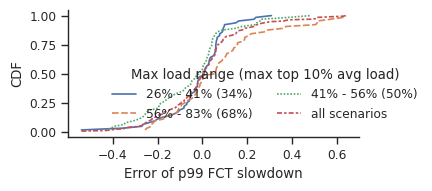

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.0), sharex=True)
# records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)['p99__ns3__pmn_m'].rank(pct=True)
# ax = sns.lineplot(data=records_lmh, x='p99__ns3__pmn_m', y='pct', hue='kind', style='kind', ci=None)
records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)['p99__ns3__pmn_mc'].rank(pct=True)
ax = sns.lineplot(data=records_lmh, x='p99__ns3__pmn_mc', y='pct', hue='kind', style='kind', ci=None)
# records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)['p99__ns3__pmn_path'].rank(pct=True)
# ax = sns.lineplot(data=records_lmh, x='p99__ns3__pmn_path', y='pct', hue='kind', style='kind', ci=None)
handles = ax.get_legend().get_lines()
ax.get_legend().remove()
title='Max load range (max top 10% avg load)'
labels=[
    f'{percentify(max_load_l_min)} - {percentify(max_load_l_max)} ({percentify(top10pct_load_l_max)})',
    f'{percentify(max_load_h_min)} - {percentify(max_load_h_max)} ({percentify(top10pct_load_h_max)})',
    f'{percentify(max_load_m_min)} - {percentify(max_load_m_max)} ({percentify(top10pct_load_m_max)})',
    'all scenarios'
]
# XXX: This is a dirty hack. Look carefully at the labels!
fig.legend(handles=handles, labels=labels, title=title, loc='lower right', frameon=False, ncol=2, bbox_to_anchor=(1.15, 0.32))
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown')
plt.ylabel('CDF')
plt.savefig('figs/error-dist-0.pdf', bbox_inches='tight')

###  Misc

In [10]:
records['p99__ns3__pmn_m'].max()
records['max_load'].quantile(0.6)
records_h['p99__ns3__pmn_m'].mean()
records[(records['oversub'] == '2-to-1') & (records['size_dist'] == 'WebServer') & (records['matrix'] == 'Matrix B')].sort_values(by='p99__ns3__pmn_m', ascending=False).iloc[:10]

,id,matrix,size_dist,lognorm_sigma,max_load_spec,max_load,top10pct_load,oversub,was__ns3__pmn_m,p99__ns3__pmn_m,was__ns3__pmn_mc,p99__ns3__pmn_mc,was__ns3__pmn_path,p99__ns3__pmn_path,kind
183,183,Matrix B,WebServer,2.0,0.466966,0.470191,0.388151,2-to-1,0.126059,0.279710,0.196707,0.385609,0.089200,0.033198,all
146,146,Matrix B,WebServer,2.0,0.487395,0.490803,0.405167,2-to-1,0.170752,0.108891,0.181868,0.258013,0.091894,0.007629,all
74,74,Matrix B,WebServer,1.0,0.590949,0.592628,0.489232,2-to-1,0.495783,0.074800,0.493606,-0.025677,0.160276,-0.024411,all
175,175,Matrix B,WebServer,1.0,0.491736,0.493031,0.407012,2-to-1,0.219040,0.063841,0.167450,-0.052393,0.111414,0.017767,all
168,168,Matrix B,WebServer,2.0,0.351868,0.354296,0.292478,2-to-1,0.084812,-0.001271,0.111109,-0.049777,0.052496,-0.011810,all
63,63,Matrix B,WebServer,2.0,0.731133,0.736026,0.607602,2-to-1,0.628769,-0.039953,0.495213,-0.006888,0.503025,-0.233491,all
24,24,Matrix B,WebServer,2.0,0.349409,0.351822,0.290436,2-to-1,0.088228,-0.060723,0.116379,-0.049058,0.059916,-0.036432,all
17,17,Matrix B,WebServer,2.0,0.259027,0.260839,0.215327,2-to-1,0.055511,-0.080105,0.073924,-0.081980,0.035197,-0.022791,all
29,29,Matrix B,WebServer,1.0,0.518351,0.519585,0.428933,2-to-1,0.248380,-0.100432,0.271310,-0.081226,0.126376,-0.254462,all
68,68,Matrix B,WebServer,2.0,0.255738,0.257506,0.212575,2-to-1,0.059153,-0.121607,0.075480,-0.141291,0.020459,-0.024623,all


### Less than 10% error?

In [11]:
pct_lt_10_l = len(records_l[records_l['p99__ns3__pmn_m'] <= 0.1]) / len(records_l)
pct_lt_10_m = len(records_m[records_m['p99__ns3__pmn_m'] <= 0.1]) / len(records_m)
pct_lt_10_h = len(records_h[records_h['p99__ns3__pmn_m'] <= 0.1]) / len(records_h)
pct_lt_10 = len(records[records['p99__ns3__pmn_m'] <= 0.1]) / len(records)
print(f'low: {percentify(pct_lt_10_l)}')
print(f'med: {percentify(pct_lt_10_m)}')
print(f'high: {percentify(pct_lt_10_h)}')
print(f'all: {percentify(pct_lt_10)}')

records_lm = pd.concat([records_l, records_m])
pct_lt_10_lm = len(records_lm[records_lm['p99__ns3__pmn_m'] <= 0.1]) / len(records_lm)
print(f'low-to-med: {int(round(pct_lt_10_lm, 2) * 100)}%')


low: 81%
med: 75%
high: 52%
all: 69%
low-to-med: 78%


### Fails to bound?

In [12]:
lt_0 = records[records['p99__ns3__pmn_m'] < 0.0]
pct_lt_0 = len(lt_0) / len(records)
print(f'{int(round(pct_lt_0, 2) * 100)}%')
print(lt_0['p99__ns3__pmn_m'].min())

21%
-0.2832303057925959


## Everything else (fix moderate load)

In [19]:
def violins(df):
    xs_labels_orders_rot = [
        ('matrix', 'Matrix', ['Matrix A', 'Matrix B', 'Matrix C'], 0),
        ('oversub', 'Oversubscription', ['1-to-1', '2-to-1', '4-to-1'], 0),
        ('size_dist', 'Flow size distribution', ['CacheFollower', 'WebServer', 'Hadoop'], 0),
        ('lognorm_sigma', 'Burstiness (log-normal σ)', [1.0, 2.0], 0),
    ]
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 3.4), sharey=True)
    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):
        j, k = i % 2, int(i / 2)
        # ax = sns.violinplot(data=df, x=x, y='p99__ns3__pmn_m', order=order, ax=axs[j, k])
        ax = sns.violinplot(data=df, x=x, y='p99__ns3__pmn_path', order=order, ax=axs[j, k])
        ax.set_xlabel(label)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
        ax.set_ylabel('')
    sns.despine()
    fig.supylabel('Error of p99 FCT slowdown')
    fig.tight_layout()

findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.


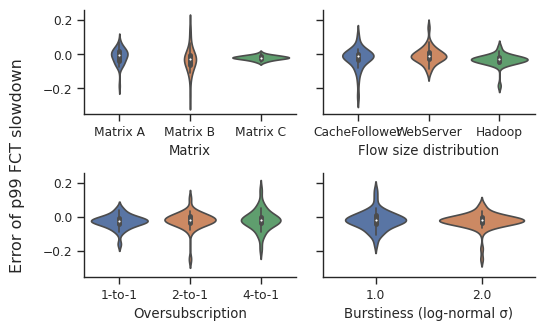

In [20]:
df_violin_lo = records[records['max_load'] <= records['max_load'].quantile(0.5)]
violins(df_violin_lo)
plt.savefig('figs/error-dist-1.pdf', bbox_inches='tight')

findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.


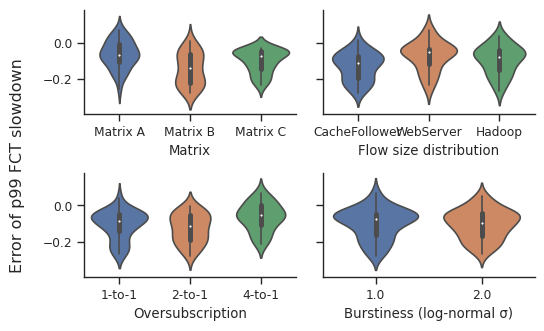

In [21]:
df_violin_hi = records[records['max_load'] > records['max_load'].quantile(0.5)]
violins(df_violin_hi)
plt.savefig('figs/error-dist-2.pdf', bbox_inches='tight')

## Scratch

In [16]:
alt.Chart(records).mark_point().encode(
    x=alt.X('max_load:Q'),
    y=alt.Y('p99__ns3__pmn_m:Q'),
    color=alt.Color('matrix:N'),
    shape=alt.Shape('size_dist:N'),
    size=alt.Size('lognorm_sigma:N'),
    opacity=alt.Opacity('oversub:N'),
    tooltip='id:N'
)

alt.Chart(...)